In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
from tqdm import tqdm
import time
import copy
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

In [2]:
# --- [✨ 추가] 최종 테스트 평가 함수 ---
def evaluate_model_on_test_set(model, test_loader, device, class_names, model_path):
    """
    학습이 완료된 후 저장된 최적의 모델을 불러와
    test 데이터셋으로 최종 성능을 평가하고, 결과를 시각화합니다.
    """
    # 저장된 최적의 가중치를 모델에 로드
    model.load_state_dict(torch.load(model_path))
    model.to(device)
    model.eval()  # 모델을 평가 모드로 설정

    all_preds = []
    all_labels = []
    running_loss = 0.0
    running_corrects = 0
    criterion = nn.CrossEntropyLoss()

    print("\n--- 최종 모델 성능 평가 (Test Set) ---")
    
    with torch.no_grad(): # 그래디언트 계산 비활성화
        for inputs, labels in tqdm(test_loader, desc="Testing"):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            _, preds = torch.max(outputs, 1)

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
            
            # 나중에 confusion matrix와 classification report를 위해 예측값과 실제값 저장
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # 전체 테스트 데이터에 대한 손실과 정확도
    test_loss = running_loss / len(test_loader.dataset)
    test_acc = running_corrects.double() / len(test_loader.dataset)
    print(f"\n✅ Test Loss: {test_loss:.4f} | Test Acc: {test_acc:.4f}\n")

    # --- Classification Report 출력 ---
    print("📋 Classification Report:")
    print(classification_report(all_labels, all_preds, target_names=class_names, digits=4))

    # --- Confusion Matrix 시각화 ---
    print("📊 Confusion Matrix:")
    cm = confusion_matrix(all_labels, all_preds)
    df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
    
    # ✨ --- 한글 폰트 설정 시작 --- ✨
    try:
        import matplotlib.pyplot as plt
        # Windows 운영체제의 경우
        plt.rc('font', family='Malgun Gothic')
    except ImportError:
        print("matplotlib 라이브러리를 찾을 수 없습니다.")
    except Exception as e:
        print(f"폰트 설정 중 오류 발생: {e}")
        print("macOS는 'AppleGothic', Linux는 'NanumGothic'을 시도해 보세요.")

    # 마이너스 기호가 깨지는 것을 방지
    plt.rcParams['axes.unicode_minus'] = False
    # ✨ --- 한글 폰트 설정 종료 --- ✨

    plt.figure(figsize=(10, 7))
    sns.heatmap(df_cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix', fontsize=16) # 타이틀 폰트 크기 조절
    plt.xlabel('Predicted Label', fontsize=12) # x축 라벨 폰트 크기 조절
    plt.ylabel('True Label', fontsize=12) # y축 라벨 폰트 크기 조절
    plt.show()


In [3]:
def train_model(model, criterion, optimizer, scheduler, num_epochs, dataloaders, device, model_save_path):
    """EfficientNet 모델을 학습하고 검증하는 메인 함수"""
    start_time = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    scaler = torch.cuda.amp.GradScaler()

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0
            progress_bar = tqdm(dataloaders[phase], desc=f"{phase.capitalize()} Phase")

            for inputs, labels in progress_bar:
                inputs = inputs.to(device)
                labels = labels.to(device)
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    with torch.cuda.amp.autocast():
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                    if phase == 'train':
                        scaler.scale(loss).backward()
                        scaler.step(optimizer)
                        scaler.update()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                progress_bar.set_postfix(loss=f'{loss.item():.4f}')

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)
            print(f'✅ {phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                torch.save(model.state_dict(), model_save_path)
                print(f'🚀 Best validation accuracy updated: {best_acc:.4f}, Model saved!')

    time_elapsed = time.time() - start_time
    print(f'\nTraining complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'🏆 Best val Acc: {best_acc:4f}')

    model.load_state_dict(best_model_wts)
    return model


Using device: cuda
------------------------------------------------------


--- (필터링된) 데이터셋 상세 정보 ---

✅ Train Dataset: 총 8787개
  - 정상: 2600개
  - 토마토잎곰팡이병: 2327개
  - 토마토황화잎말림바이러스병: 2015개
  - 토마토흰가루병: 1845개

✅ Val Dataset: 총 1290개
  - 정상: 375개
  - 토마토잎곰팡이병: 342개
  - 토마토황화잎말림바이러스병: 300개
  - 토마토흰가루병: 273개

✅ Test Dataset: 총 1294개
  - 정상: 377개
  - 토마토잎곰팡이병: 341개
  - 토마토황화잎말림바이러스병: 301개
  - 토마토흰가루병: 275개
---------------------------

Class names: ['정상', '토마토잎곰팡이병', '토마토황화잎말림바이러스병', '토마토흰가루병']
Number of classes: 4
Epoch 1/15
----------


C:\Users\427s2\AppData\Local\Temp\ipykernel_23824\1756973827.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()
Train Phase:   0%|          | 0/275 [00:00<?, ?it/s]C:\Users\427s2\AppData\Local\Temp\ipykernel_23824\1756973827.py:28: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Train Phase: 100%|██████████| 275/275 [00:31<00:00,  8.83it/s, loss=0.1336]


✅ train Loss: 0.2113 Acc: 0.9276


Val Phase: 100%|██████████| 41/41 [00:14<00:00,  2.89it/s, loss=0.0122]


✅ val Loss: 0.0341 Acc: 0.9907
🚀 Best validation accuracy updated: 0.9907, Model saved!
Epoch 2/15
----------


Train Phase: 100%|██████████| 275/275 [00:29<00:00,  9.31it/s, loss=0.1869]


✅ train Loss: 0.1060 Acc: 0.9648


Val Phase: 100%|██████████| 41/41 [00:13<00:00,  3.07it/s, loss=0.0981]


✅ val Loss: 0.0508 Acc: 0.9798
Epoch 3/15
----------


Train Phase: 100%|██████████| 275/275 [00:30<00:00,  9.17it/s, loss=0.0979]


✅ train Loss: 0.0870 Acc: 0.9688


Val Phase: 100%|██████████| 41/41 [00:13<00:00,  3.04it/s, loss=0.0002]


✅ val Loss: 0.0303 Acc: 0.9907
Epoch 4/15
----------


Train Phase: 100%|██████████| 275/275 [00:29<00:00,  9.33it/s, loss=0.0074]


✅ train Loss: 0.0731 Acc: 0.9756


Val Phase: 100%|██████████| 41/41 [00:13<00:00,  3.04it/s, loss=0.0004]


✅ val Loss: 0.0425 Acc: 0.9829
Epoch 5/15
----------


Train Phase: 100%|██████████| 275/275 [00:30<00:00,  9.13it/s, loss=0.0641]


✅ train Loss: 0.0633 Acc: 0.9789


Val Phase: 100%|██████████| 41/41 [00:13<00:00,  3.05it/s, loss=0.0069]


✅ val Loss: 0.0303 Acc: 0.9884
Epoch 6/15
----------


Train Phase: 100%|██████████| 275/275 [00:29<00:00,  9.26it/s, loss=0.0368]


✅ train Loss: 0.0634 Acc: 0.9803


Val Phase: 100%|██████████| 41/41 [00:13<00:00,  3.05it/s, loss=0.0005]


✅ val Loss: 0.0093 Acc: 0.9961
🚀 Best validation accuracy updated: 0.9961, Model saved!
Epoch 7/15
----------


Train Phase: 100%|██████████| 275/275 [00:30<00:00,  9.02it/s, loss=0.0008]


✅ train Loss: 0.0533 Acc: 0.9835


Val Phase: 100%|██████████| 41/41 [00:13<00:00,  3.06it/s, loss=0.0008]


✅ val Loss: 0.0233 Acc: 0.9930
Epoch 8/15
----------


Train Phase: 100%|██████████| 275/275 [00:29<00:00,  9.24it/s, loss=0.0035]


✅ train Loss: 0.0386 Acc: 0.9857


Val Phase: 100%|██████████| 41/41 [00:13<00:00,  2.99it/s, loss=0.0021]


✅ val Loss: 0.0120 Acc: 0.9961
Epoch 9/15
----------


Train Phase: 100%|██████████| 275/275 [00:30<00:00,  9.06it/s, loss=0.0098]


✅ train Loss: 0.0243 Acc: 0.9920


Val Phase: 100%|██████████| 41/41 [00:13<00:00,  3.06it/s, loss=0.0015]


✅ val Loss: 0.0092 Acc: 0.9977
🚀 Best validation accuracy updated: 0.9977, Model saved!
Epoch 10/15
----------


Train Phase: 100%|██████████| 275/275 [00:29<00:00,  9.27it/s, loss=0.0007]


✅ train Loss: 0.0183 Acc: 0.9945


Val Phase: 100%|██████████| 41/41 [00:13<00:00,  3.04it/s, loss=0.0007]


✅ val Loss: 0.0066 Acc: 0.9984
🚀 Best validation accuracy updated: 0.9984, Model saved!
Epoch 11/15
----------


Train Phase: 100%|██████████| 275/275 [00:30<00:00,  9.12it/s, loss=0.0202]


✅ train Loss: 0.0189 Acc: 0.9939


Val Phase: 100%|██████████| 41/41 [00:13<00:00,  3.04it/s, loss=0.0011]


✅ val Loss: 0.0064 Acc: 0.9984
Epoch 12/15
----------


Train Phase: 100%|██████████| 275/275 [00:29<00:00,  9.19it/s, loss=0.0025]


✅ train Loss: 0.0168 Acc: 0.9950


Val Phase: 100%|██████████| 41/41 [00:13<00:00,  2.98it/s, loss=0.0056]


✅ val Loss: 0.0058 Acc: 0.9977
Epoch 13/15
----------


Train Phase: 100%|██████████| 275/275 [00:29<00:00,  9.23it/s, loss=0.0191]


✅ train Loss: 0.0160 Acc: 0.9952


Val Phase: 100%|██████████| 41/41 [00:13<00:00,  3.04it/s, loss=0.0020]


✅ val Loss: 0.0035 Acc: 0.9992
🚀 Best validation accuracy updated: 0.9992, Model saved!
Epoch 14/15
----------


Train Phase: 100%|██████████| 275/275 [00:29<00:00,  9.24it/s, loss=0.0014]


✅ train Loss: 0.0180 Acc: 0.9943


Val Phase: 100%|██████████| 41/41 [00:13<00:00,  3.03it/s, loss=0.0019]


✅ val Loss: 0.0037 Acc: 0.9992
Epoch 15/15
----------


Train Phase: 100%|██████████| 275/275 [00:30<00:00,  9.12it/s, loss=0.0116]


✅ train Loss: 0.0128 Acc: 0.9964


Val Phase: 100%|██████████| 41/41 [00:13<00:00,  3.05it/s, loss=0.0039]


✅ val Loss: 0.0048 Acc: 0.9984

Training complete in 10m 54s
🏆 Best val Acc: 0.999225

--- 최종 모델 성능 평가 (Test Set) ---


Testing: 100%|██████████| 41/41 [00:14<00:00,  2.93it/s]


✅ Test Loss: 0.0133 | Test Acc: 0.9985

📋 Classification Report:
               precision    recall  f1-score   support

           정상     1.0000    0.9973    0.9987       377
     토마토잎곰팡이병     0.9971    1.0000    0.9985       341
토마토황화잎말림바이러스병     1.0000    0.9967    0.9983       301
      토마토흰가루병     0.9964    1.0000    0.9982       275

     accuracy                         0.9985      1294
    macro avg     0.9984    0.9985    0.9984      1294
 weighted avg     0.9985    0.9985    0.9985      1294

📊 Confusion Matrix:


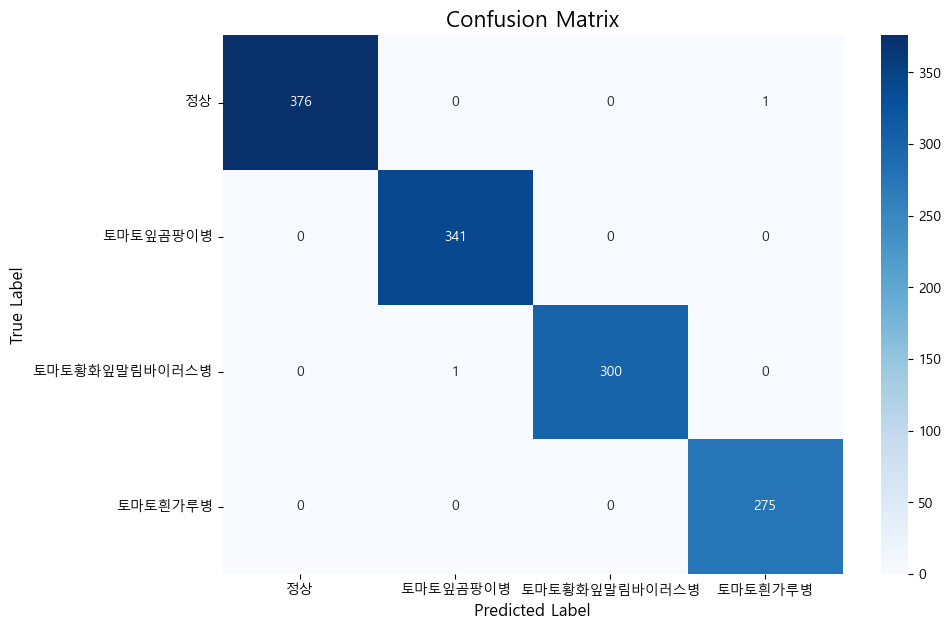

In [133]:
if __name__ == '__main__':
    # --- 1. 설정 및 하이퍼파라미터 ---
    DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {DEVICE}")

    DATA_PATH = r'C:\Users\427s2\KSEB\tomato\final_dataset'
    MODEL_SAVE_PATH = 'new_tomato_classifier_ver3.pth'
    
    IMG_SIZE = 240
    BATCH_SIZE = 32
    NUM_EPOCHS = 15
    LEARNING_RATE = 0.001
    # CLASS_TO_EXCLUDE = 'x단호박점무늬병' # 제외할 클래스 이름

    # --- 2. 데이터 전처리 및 로더 준비 ---
    data_transforms = {
        'train': transforms.Compose([
            transforms.RandomResizedCrop(IMG_SIZE),
            transforms.RandomHorizontalFlip(),
            transforms.RandomRotation(15),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]),
        'val': transforms.Compose([
            transforms.Resize(IMG_SIZE),
            transforms.CenterCrop(IMG_SIZE),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]),
        'test': transforms.Compose([
            transforms.Resize(IMG_SIZE),
            transforms.CenterCrop(IMG_SIZE),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]),
    }

    image_datasets = {x: datasets.ImageFolder(os.path.join(DATA_PATH, x), data_transforms[x])
                    for x in ['train', 'val', 'test']}
    
    # ==================================================================
    # ✨ [수정된 부분] 특정 클래스 제외 로직
    """
    print(f"\n--- 데이터셋 필터링 시작: '{CLASS_TO_EXCLUDE}' 클래스 제외 ---")
    
    for split in ['train', 'val', 'test']:
        dataset = image_datasets[split]
        
        # 1. 제외할 클래스의 인덱스 찾기
        if CLASS_TO_EXCLUDE not in dataset.class_to_idx:
            print(f"'{CLASS_TO_EXCLUDE}' 클래스를 {split} 데이터셋에서 찾을 수 없습니다. 건너뜁니다.")
            continue
            
        exclude_idx = dataset.class_to_idx[CLASS_TO_EXCLUDE]

        # 2. 해당 클래스를 제외한 샘플(이미지 경로, 레이블)만 필터링
        original_samples = dataset.samples
        filtered_samples = [s for s in original_samples if s[1] != exclude_idx]
        
        # 3. 클래스 목록과 class_to_idx 딕셔너리 재구성
        new_classes = [c for c in dataset.classes if c != CLASS_TO_EXCLUDE]
        new_class_to_idx = {cls_name: i for i, cls_name in enumerate(new_classes)}
        
        # 4. 필터링된 샘플들의 레이블을 새로운 인덱스(0, 1, 2...)로 재매핑
        #    예: [0, 2, 3] -> [0, 1, 2]
        remapped_samples = []
        for path, old_idx in filtered_samples:
            old_class_name = dataset.classes[old_idx]
            new_idx = new_class_to_idx[old_class_name]
            remapped_samples.append((path, new_idx))

        # 5. 데이터셋 객체의 속성을 갱신
        dataset.samples = remapped_samples
        dataset.imgs = remapped_samples
        dataset.classes = new_classes
        dataset.class_to_idx = new_class_to_idx
        dataset.targets = [s[1] for s in remapped_samples]
    """
    print("------------------------------------------------------\n")
    # ==================================================================
    
    # ==================================================================
    # ✨ [추가된 부분] 데이터셋 상세 정보 출력
    print("\n--- (필터링된) 데이터셋 상세 정보 ---")
    for split in ['train', 'val', 'test']:
        dataset = image_datasets[split]
        class_names_list = dataset.classes
        class_counts = {class_name: 0 for class_name in class_names_list}
        for _, label_idx in dataset.samples:
            class_name = class_names_list[label_idx]
            class_counts[class_name] += 1
        
        print(f"\n✅ {split.capitalize()} Dataset: 총 {len(dataset)}개")
        # 클래스 이름 순서가 폴더 순서에 따라 달라질 수 있으므로, 정렬해서 출력
        for class_name in sorted(class_counts.keys()):
            print(f"  - {class_name}: {class_counts[class_name]}개")
    print("---------------------------\n")
    # ==================================================================

    dataloaders = {
        'train': DataLoader(image_datasets['train'], batch_size=BATCH_SIZE, shuffle=True, num_workers=4),
        'val': DataLoader(image_datasets['val'], batch_size=BATCH_SIZE, shuffle=False, num_workers=4),
        'test': DataLoader(image_datasets['test'], batch_size=BATCH_SIZE, shuffle=False, num_workers=4)
    }
    
    class_names = image_datasets['train'].classes
    NUM_CLASSES = len(class_names)
    print("Class names:", class_names)
    print(f"Number of classes: {NUM_CLASSES}")

    # --- 3. 모델 준비 ---
    model = models.efficientnet_b1(weights=models.EfficientNet_B1_Weights.DEFAULT)
    num_ftrs = model.classifier[1].in_features
    model.classifier[1] = nn.Linear(num_ftrs, NUM_CLASSES)
    model = model.to(DEVICE)

    # --- 4. 손실 함수, 옵티마이저, 스케줄러 정의 ---
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
    exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

    # --- 5. 모델 학습 시작 ---
    trained_model = train_model(model, criterion, optimizer, exp_lr_scheduler,
                                num_epochs=NUM_EPOCHS, 
                                dataloaders={'train': dataloaders['train'], 'val': dataloaders['val']}, 
                                device=DEVICE, 
                                model_save_path=MODEL_SAVE_PATH)

    # --- 6. 학습 완료 후 Test Set으로 최종 평가 ---
    evaluate_model_on_test_set(model=trained_model, 
                            test_loader=dataloaders['test'], 
                            device=DEVICE, 
                            class_names=class_names,
                            model_path=MODEL_SAVE_PATH)

In [2]:
import torch
import torch.nn.functional as F
from torchvision import models, transforms
from PIL import Image
from collections import defaultdict
import json
import os
import glob

def predict_image(model_path, image_path, class_names, device):
    """
    학습된 모델을 로드하여 단일 이미지의 클래스를 예측합니다.

    Args:
        model_path (str): 저장된 모델 파일(.pth)의 경로
        image_path (str): 테스트할 이미지 파일의 경로
        class_names (list): 학습 시 사용된 클래스 이름 리스트
        device (torch.device): 연산을 수행할 장치 (cpu 또는 cuda)

    Returns:
        tuple: (예측된 클래스 이름, 신뢰도 확률)
    """
    # 1. 모델 아키텍처 불러오기 및 최종 레이어 수정
    num_classes = len(class_names)
    model = models.efficientnet_b1(weights=None) # 사전학습 가중치는 사용 안 함
    num_ftrs = model.classifier[1].in_features
    model.classifier[1] = torch.nn.Linear(num_ftrs, num_classes)

    # 2. 학습된 가중치(state_dict) 로드
    model.load_state_dict(torch.load(model_path, map_location=device))
    model = model.to(device)
    model.eval()  # 모델을 평가 모드로 설정 (dropout, batchnorm 비활성화)

    # 3. 이미지 전처리 (학습 시 validation 단계와 동일하게)
    preprocess = transforms.Compose([
        transforms.Resize(240),
        transforms.CenterCrop(240),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

    try:
        image = Image.open(image_path).convert('RGB')
        image_tensor = preprocess(image).unsqueeze(0).to(device) # 배치 차원 추가
    except FileNotFoundError:
        return f"오류: '{image_path}' 파일을 찾을 수 없습니다.", 0.0

    # 4. 예측 수행
    with torch.no_grad(): # 그래디언트 계산 비활성화
        outputs = model(image_tensor)
        # Softmax를 적용하여 확률로 변환
        probabilities = F.softmax(outputs, dim=1)
        # 가장 높은 확률과 해당 인덱스 가져오기
        confidence, predicted_idx = torch.max(probabilities, 1)

    # 5. 결과 반환
    predicted_class = class_names[predicted_idx.item()]
    confidence_score = confidence.item() * 100

    return predicted_class, confidence_score

In [9]:
if __name__ == '__main__':
    # --- 설정 ---
    DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # 📂 학습된 모델 파일 경로
    MODEL_PATH = r'C:\Users\A\Desktop\PGH_folder\kyonggi_univ\KSEB\fastapi\app\ai_models\new_tomato_classifier_ver2.pth'
    
    # 🖼️ 테스트하고 싶은 이미지 파일 경로 (이 부분을 수정하세요!)
    IMAGE_TO_TEST = r'C:\Users\A\Desktop\PGH_folder\kyonggi_univ\KSEB\fastapi\test_data\tomato\토마토황화잎말림바이러스병7.jpg' 
    
    # ❗ 클래스 이름 (train.py에서 사용한 순서와 반드시 동일해야 함)
    CLASS_NAMES = ['정상', '토마토잎곰팡이병', '토마토황화잎말림바이러스병', '토마토흰가루병']  
    
    # --- 예측 실행 ---
    predicted_class, confidence = predict_image(MODEL_PATH, IMAGE_TO_TEST, CLASS_NAMES, DEVICE)
    
    if "오류" in predicted_class:
        print(predicted_class)
    else:
        print("\n--- 예측 결과 ---")
        print(f"✅ 이미지: {IMAGE_TO_TEST}")
        print(f"🔍 예측된 클래스: **{predicted_class}**")
        print(f"🎯 신뢰도: **{confidence:.2f}%**")


--- 예측 결과 ---
✅ 이미지: C:\Users\A\Desktop\PGH_folder\kyonggi_univ\KSEB\fastapi\test_data\tomato\토마토황화잎말림바이러스병7.jpg
🔍 예측된 클래스: **토마토황화잎말림바이러스병**
🎯 신뢰도: **96.84%**


In [199]:
if __name__ == '__main__':
    # --- 설정 ---
    DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # 📂 학습된 모델 파일 경로
    MODEL_PATH = r'C:\Users\427s2\KSEB\tomato\new_tomato_classifier_ver3.pth'
    
    # 🖼️ 테스트할 이미지들이 들어있는 **폴더** 경로 (이 부분을 수정하세요!)
    TEST_DATA_FOLDER = r'C:\Users\427s2\KSEB\tomato\test_data' 
    
    # ❗ 클래스 이름 (train.py에서 사용한 순서와 반드시 동일해야 함)
    CLASS_NAMES = ['정상', '토마토잎곰팡이병', '토마토황화잎말림바이러스병', '토마토흰가루병']  
    
    # --- 폴더 내 모든 이미지 경로 가져오기 ---
    # 폴더 내의 모든 .jpg, .jpeg, .png, .bmp 파일을 찾습니다.
    image_paths = []
    supported_formats = ['*.jpg', '*.jpeg', '*.png', '*.bmp']
    for fmt in supported_formats:
        # glob을 사용하여 특정 패턴의 파일 경로를 리스트로 만듭니다.
        image_paths.extend(glob.glob(os.path.join(TEST_DATA_FOLDER, fmt)))
        
    if not image_paths:
        print(f"❌ 오류: '{TEST_DATA_FOLDER}' 폴더에서 이미지를 찾을 수 없습니다.")
    else:
        print(f"총 {len(image_paths)}개의 이미지를 테스트합니다.\n")
    
    # --- 예측 실행 및 결과 집계 ---
    # 각 클래스별 예측 횟수를 저장하기 위한 딕셔너리
    prediction_counts = defaultdict(int)
    
    # 찾은 모든 이미지에 대해 반복 실행
    for image_path in image_paths:
        # 기존 예측 함수를 그대로 호출
        predicted_class, confidence = predict_image(MODEL_PATH, image_path, CLASS_NAMES, DEVICE)
        
        # 파일 이름만 깔끔하게 추출
        image_filename = os.path.basename(image_path)
        
        if "오류" in predicted_class:
            print(f"이미지: {image_filename} - {predicted_class}")
        else:
            print(f"✅ 이미지: {image_filename}")
            print(f"   - 예측: **{predicted_class}** (신뢰도: {confidence:.2f}%)")
            print("-" * 30) # 결과 구분을 위한 라인
            
            # 예측 결과 횟수 증가
            prediction_counts[predicted_class] += 1
            
    # --- 최종 결과 요약 ---
    print("\n\n--- 📊 최종 예측 결과 요약 ---")
    print(f"총 테스트 이미지: {len(image_paths)}개")
    for class_name, count in prediction_counts.items():
        print(f"- **{class_name}**: {count}개")

총 36개의 이미지를 테스트합니다.

✅ 이미지: 토마토_정상1.jpg
   - 예측: **정상** (신뢰도: 99.80%)
------------------------------
✅ 이미지: 토마토_정상2.jpg
   - 예측: **정상** (신뢰도: 97.13%)
------------------------------
✅ 이미지: 토마토_정상3.jpg
   - 예측: **정상** (신뢰도: 99.96%)
------------------------------
✅ 이미지: 토마토_정상4.jpg
   - 예측: **정상** (신뢰도: 96.17%)
------------------------------
✅ 이미지: 토마토_정상5.jpg
   - 예측: **정상** (신뢰도: 100.00%)
------------------------------
✅ 이미지: 토마토_정상6.jpg
   - 예측: **정상** (신뢰도: 100.00%)
------------------------------
✅ 이미지: 토마토잎곰팡이병1.jpg
   - 예측: **토마토잎곰팡이병** (신뢰도: 100.00%)
------------------------------
✅ 이미지: 토마토잎곰팡이병10.jpg
   - 예측: **토마토잎곰팡이병** (신뢰도: 100.00%)
------------------------------
✅ 이미지: 토마토잎곰팡이병2.jpg
   - 예측: **토마토잎곰팡이병** (신뢰도: 99.62%)
------------------------------
✅ 이미지: 토마토잎곰팡이병3.jpg
   - 예측: **토마토잎곰팡이병** (신뢰도: 100.00%)
------------------------------
✅ 이미지: 토마토잎곰팡이병4.jpg
   - 예측: **토마토잎곰팡이병** (신뢰도: 99.90%)
------------------------------
✅ 이미지: 토마토잎곰팡이병5.jpg
   - 예측: **토마토잎곰팡이병** (신뢰도: 98.0